In [1]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dropout,Dense,LSTM
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load the excel data

df = pd.read_excel('Oil well.xlsx',header=2)
df.head()

,Date,\nOil volume (m3/day),Volume of liquid (m3/day),\nGas volume (m3/day),Water volume (m3/day),Water cut (%),\nWorking hours,\nDynamic level (m),\nReservoir pressure (atm)
0,2013-01-01,49,70,13055,21,29,24,1819,214
1,2013-01-02,49,70,13055,21,29,24,1836,214
2,2013-01-03,49,70,13055,21,29,24,1788,214
3,2013-01-04,49,70,13055,21,29,24,1789,214
4,2013-01-05,44,70,11768,26,36,24,1825,214


In [3]:
# rename the columns

col_mapper = {'\nOil volume (m3/day)':'Oil_volume',
             'Volume of liquid (m3/day)':'Volume_of_liquid',
             '\nGas volume (m3/day)':'Gas_volume',
             'Water volume (m3/day)':'Water_volume',
             'Water cut (%)':'Water_cut',
             '\nWorking hours':'Working_hours',
             '\nDynamic level (m)':'Dynamic_level',
             '\nReservoir pressure (atm)':'Reservoir_pressure'}

df.rename(col_mapper,axis=1,inplace=True)

In [4]:
# set the column names as a lowercase

df.columns = df.columns.str.lower()

In [5]:
# set the date column as index

df.set_index('date',inplace=True)

In [6]:
# select the oil volume column for prediction

df_temp = df['oil_volume'].copy()

In [7]:
df_temp.head()

date
2013-01-01    49
2013-01-02    49
2013-01-03    49
2013-01-04    49
2013-01-05    44
Name: oil_volume, dtype: int64

In [8]:
# shape of the time series data for the oil well column

df_temp.shape

(2939,)

In [9]:
# min max scaling of the input

min_max = MinMaxScaler()

X_train_scaled = min_max.fit_transform(df_temp.values.reshape(-1,1))

In [10]:
# create the data

X_train = []
y_train = []

for i in range(60,len(df)):  # create the data for 60 timesteps (history of about 2 months)
    X_train.append(X_train_scaled[i-60:i,0])
    y_train.append(X_train_scaled[i,0])
    

In [11]:
import numpy as np

In [12]:
# convert the list into arrays

X_train = np.array(X_train)
print(X_train.shape)

y_train = np.array(y_train)
print(y_train.shape)

(2879, 60)
(2879,)


In [13]:
# reshape the train data for input in the model

X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))

In [14]:
# shape of X_train 

X_train.shape

(2879, 60, 1)

In [15]:
# build the model

model = Sequential()

# add the first LSTM layer
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(Dropout(rate=0.2))


# add the second LSTM layer
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(rate=0.2))
          
# add the third LSTM layer
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(rate=0.2))

# add fourth LSTM layer
model.add(LSTM(units=50,return_sequences=False))
model.add(Dropout(rate=0.2))
          
# add output layer
          
model.add(Dense(units=1))
          

In [16]:
# generate the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [17]:
# compile the model

model.compile(optimizer='adam',loss='mean_squared_error',run_eagerly=True)

In [18]:
# fit the model

history = model.fit(X_train,y_train,epochs=5,workers=2)

Epoch 1/5
90/90 [==============================] - 124s 1s/step - loss: 0.0141
Epoch 2/5
90/90 [==============================] - 118s 1s/step - loss: 0.0054
Epoch 3/5
90/90 [==============================] - 114s 1s/step - loss: 0.0055
Epoch 4/5
90/90 [==============================] - 119s 1s/step - loss: 0.0053
Epoch 5/5
90/90 [==============================] - 113s 1s/step - loss: 0.0048


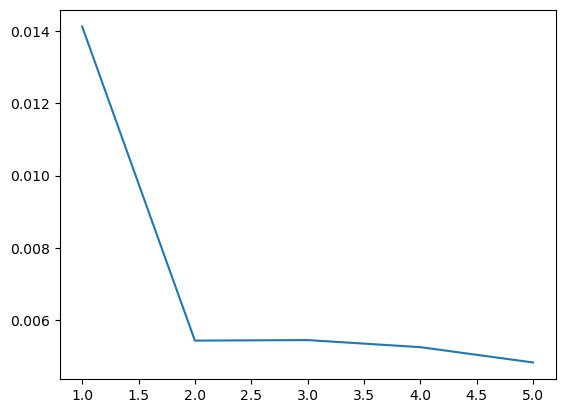

In [19]:
# plot the loss function of the model for each epoch

plt.plot(range(1,6),history.history['loss'])
plt.show()

In [20]:
# predict on the train data

y_pred = model.predict(X_train)

90/90 [==============================] - 50s 556ms/step


In [21]:
# shape of the y_pred

y_pred.shape

(2879, 1)

In [22]:
# calculate the loss of the model on the train data

from sklearn.metrics import mean_squared_error

loss = np.sqrt(mean_squared_error(y_train,y_pred))
print('The RMSE is',loss)

The RMSE is 0.07562689286746525


In [23]:
# inverse transform the scaled data

y_pred_inv = min_max.inverse_transform(y_pred) # bring the train predictions to original scale

In [24]:
# shape of the inverse transformed data

y_pred_inv.shape

(2879, 1)

In [43]:
# scale the input data

x = df_temp.rolling(window=25).mean()
x.dropna(inplace=True)

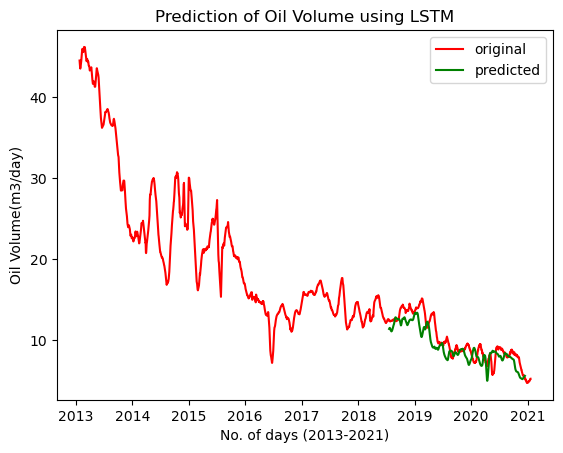

In [44]:
# plot the graph

plt.plot(x[:],color='red',label='original')
plt.plot(x.index[2000:2879],y_pred_inv[2000:],color='green',label='predicted')
plt.legend()
plt.title('Prediction of Oil Volume using LSTM')
plt.xlabel('No. of days (2013-2021)')
plt.ylabel('Oil Volume(m3/day)')
plt.savefig('prediction.png')

In [41]:
# generate the dataframe of the result

original = x[2000:2879].values

predicted = y_pred_inv[2000:2879]

# dataframe

result_df = pd.DataFrame()

result_df['Actual'] = original

result_df['Prediction'] = predicted

result_df['Difference'] = result_df['Actual'] - result_df['Prediction']

result_df['Prediction'] = result_df['Prediction'].apply(np.round,args=(2,)) 

# print the results dataframe

result_df.set_index(df_temp.index[2000:2879])

,Actual,Prediction,Difference
date,,,
2018-06-25,12.20,11.35,0.848829
2018-06-26,12.16,11.40,0.763071
2018-06-27,12.12,11.44,0.682980
2018-06-28,12.08,11.47,0.613751
2018-06-29,12.12,11.48,0.638418
...,...,...,...
2020-11-15,6.76,5.45,1.305186
2020-11-16,6.68,5.47,1.206722
2020-11-17,6.56,5.49,1.065757


In [42]:
# save the results dataframe

result_df.to_csv('results.csv')